# Chapter 3
## Classification using the MNIST dataset

The following code fetches the MNIST dataset

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Data sets loaded by scikit generally have dictionary structure, and they include the following:
    1. A DESCR key, describing the dataset
    2. A data key containing an array with one row per instance and one column per feature
    3. A target key, containing an array with all the labels

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape
#y.shape

(70000, 784)

We see that the X matrix contains 70,000 instances (images) and 784 features(pixels)

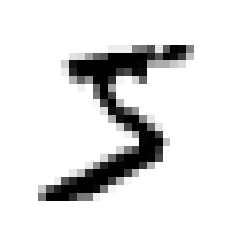

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0] #its a numpy array fyi
some_digit_image = some_digit.reshape(28,28) #reshaping vector into a matrix

plt.imshow(some_digit_image, cmap = 'binary')
plt.axis('off')
plt.show()

In [5]:
y[0] #verify if this in fact is a 5

'5'

In [6]:
type(y[0])

str

Note that this is a string, we have to cast it into an integer so that we can use it in our ML algorithm

In [7]:
import numpy as np
y = y.astype(np.uint8)
type(y[0])

numpy.uint8

Before further inspecting the data, it is always important to separate the data into the test and training sets so that we don't have any biases. The MNIST dataset is already ordered into a training set, and a test set. The former is the first 60,000 images and the latter is the remaining 10,000 images. 

let's split it up:


In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### Training a  Binary Classifier
Let's train a binary classifier that detects if the number is a 5 or not. 

In [9]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)#Returns an array with elements containing True for all 5's in the array. 

Let's tray Stochastic Gradient Descent (SGD)

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)#Note that we're using the train set and using as labels true and falses to train it

SGDClassifier(random_state=42)

In [11]:
sgd_clf.predict([some_digit])#Check if it correctly guesses our 'five' instance

array([ True])

### Performance Measures
Let's try using cross-validation as we did in chapter 2 to evaluate our algorithm's performance

In [12]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Sheesh, over 93% accuracy??

Let's test a dumb classifier that says every digit is not a 5. 

In [13]:
from sklearn.base import BaseEstimator 

class Never5Classifier(BaseEstimator):#Create the class of our transformer, remember that it must have fit() method
    def fit(self, X, y = None):
        return self
    def predict(self, X):
        return np.zeros((len(X),1),dtype = bool)

In [14]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.91125, 0.90855, 0.90915])

By just saying no everytime, we get >90% accuracy. This is why accuracy is no not the preferred performance measurement for skewed datasets(datasets that have classes that are more frequent than others)

### Confusion Matrix
The general idea is to count the number of instances from class A that are classified as class B.

using cross_val_predict(), we get a list of predictions that uses folds (just like the cross_val_scores()) to predict the value of that particular fold in such a way that the predictions are always clean. Clean meaning that the prediction was made using a model that never saw the data during training.

In [15]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Let's fit it into the confusion metrics function


In [16]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

Let's use an array that acts like we guessed perfectly:



In [17]:
y_train_perfect_predictions = y_train_5 #pretend we reached percection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

The main diagonals are the only elements with non-zero values.

In [18]:
from sklearn.metrics import precision_score, recall_score 
precision_score(y_train_5,y_train_pred)
recall_score(y_train_5, y_train_pred)


0.6511713705958311

In [19]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5,y_train_pred)

0.8370879772350012

In [20]:
recall_score(y_train_5,y_train_pred)

0.6511713705958311

We'll introduce the F1 Score, which is a harmonic mean.

Whereas regular means treat values equally, harmonic means give much more weight to low values. As a result, the classifier will only get a high result if both recall and precision are high.

In [21]:
from sklearn.metrics import f1_score
f1_score(y_train_5,y_train_pred)

0.7325171197343846

Depending on the situation, you may prefer low recall and high precision or viceversa, but the point is that its a tradeoff.

### Precision/Recall Tradeoff

SGD Classifiers use a decision function that assigns a grade to each instance. Then, it sets a treshold and depending on what that reshold is, you can get different values of precision and recall. 


In [22]:
y_scores = sgd_clf.decision_function([some_digit]) #Instead of predicting the number, lets compute its decision f value
y_scores
treshold = 0 #default for SGD
y_some_digit_pred = (y_scores > treshold)
y_some_digit_pred #Verify that we get the same result

array([ True])

Lets raise the treshold:

In [23]:
treshold = 8000
y_some_digit_pred = (y_scores > treshold)
y_some_digit_pred

array([False])

We see that this actually decreases the precision. But how do we decide the treshold? Lets use the cross_val_predict() function to get the scores of all instances in the training set, but we want decision scores instead of predictions. 

In [24]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = 'decision_function')

With these scores we'll take a look at a precision_recall_curve function to compute recall and precision for different treshold. Instead of returning a prediction for each instance, it returns the decision function function for each instance.


In [25]:
from sklearn.metrics import precision_recall_curve 

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)


In [26]:
#All of the following code is copied from the book's Github page because it isn't included in the book, they're
#specifics about the graphs.

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    plt.axis([-50000, 50000, 0, 1])             






#plt.figure(figsize=(8, 4))                                                                  
#plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
#plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")           
#plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                               
#plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
#plt.plot([threshold_90_precision], [0.9], "ro")                                             
#plt.plot([threshold_90_precision], [recall_90_precision], "ro")                                                                       # Not shown
#plt.show()

Note that precision can drop when the threshold is pushed up, but recall can't. This is because precision is based on the number of positive predictions. So if the threshold is pushed up, the denominator can change as well as the numerator.

When you increase the threshold, recall can only go down because the only thing you're changing is the numerator. The number of elements in the actual class is always the same. 


In [27]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] #first index of the maximum value
#which in this case will give us a 1 whenever the precision is greater that 90%
threshold_90_precision

3370.0194991439557

In [28]:
y_train_pred_90 = (y_scores >= threshold_90_precision)#Set true all of the instances that have a greater score than the threshold
precision_score(y_train_5, y_train_pred_90) #Calculate precision score for those predictions

0.9000345901072293

In [29]:
recall_score(y_train_5, y_train_pred_90) #Calculate recall scores for the same predictions

0.4799852425751706

In general, we can achieve any precision we set out to get, but we don't want to have a low recall as well.

### The ROC curve
The receiver operating characteristic (ROC) curve is another very common tool used to with binary classifiers. 

In this case, instead of plotting precision vs recall, we plot recall (True Positive Rate) against false positive rate.


In [30]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

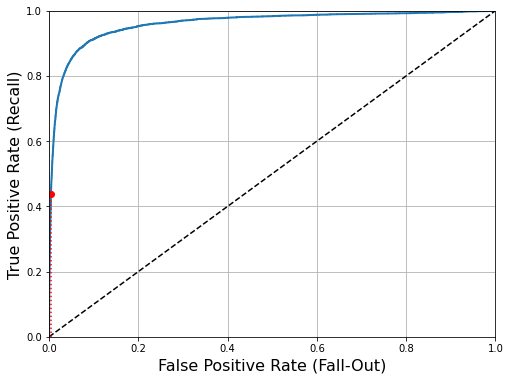

In [31]:
#Once again, the following code is copied from the book's Github
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

This graph shows that when TPR increases, FPR will inevitably increase, aka, there will be more false positives from the classifier. 

Note: The red note is the chosen threshold using np.argmax()


In [32]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)


0.9604938554008616

Now let's train a RandomForrestClassifier, which doesn't have a decision score, but instead a predict_proba(), which returns an array with a row per instance, and a column per class, each containing the probability that the given instance belongs to the given class. 

In [33]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, method = 'predict_proba')

y_scores_forest = y_probas_forest[:, 1] #Set the score to be the probability calculated by the forest
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)



Now let's plot the ROC for both, the SGD classifier and the RandomForestClassifier:

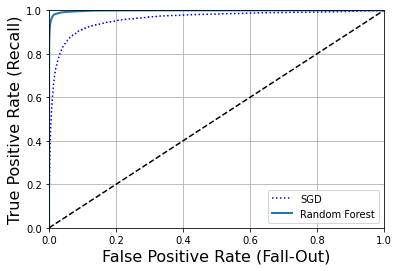

In [34]:
plt.plot(fpr, tpr, 'b:', label = 'SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc = 'lower right')

plt.show()

In [35]:
roc_auc_score(y_train_5, y_scores_forest) #Remember that a perfect AUC score is 1 and a random classifier will be 
#0.5

0.9983436731328145

In [36]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [37]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

### Multiclass Classification


There are multiple classifiers that are natively prepared to perform multiclass classifications, like SGD, Random Forest Classifies and Naive Bayes. Other classifiers like SVM or Logistical Regression classifiers are strictly binary classifiers. There is one way to use multiple binary classifiers to perform multiclass classification. 

If we create a system to detect the digit(0 - 9), we can train a binary classifier for each digit and then compute the decision score for each classifier and select the class whose classifier outputs the highest score: One-versus-the-rest(OvR) or one-versus-all.

In one versus the rest, the system looks for the classifier with the highes score, while in the One versus One, you train classifiers on pairs of numbers(only using training sets that contain that class) and then you run all of the classifiers on that image, selecting the class wins the most duels. 

Scikit detects when you're trying to use a binary classification algorithm for a multiclass clasiffication task.




In [40]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train,y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [41]:
some_digit_scores = svm_clf.decision_function([some_digit])#Fetching the decision score for an instance
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

The highest score indeed corresponds to the number 5:


In [42]:
np.argmax(some_digit_scores)#Numpy's argmax returns an index

5

In [43]:
svm_clf.classes_#What classes did the classes identify

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

If you want to specify OvR or OvO ypou can import a OneVsOneClassifier or OneVsRestClassifier class. You create an instance and then pass a classifier to its constructor.


In [45]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [46]:
len(ovr_clf.estimators_)

10

Training an SGDClassifier is similar:

In [47]:
sgd_clf.fit(X_train,y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

This time SciKit did not have to run OvR or OvO because SGD classifiers are natively multiclass classifiers. Let's check the decision function outputs though:


In [48]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

You can see that the classifier is fairly confident that this is a five, since all the other classes have been rated with negative numbers, except 3, which kind of makes sense.

In [57]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

This does much better than a Random Classifier would do, let's try scaling the data so that we get better results:

In [59]:
2+2

4

In [60]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv =3, scoring = 'accuracy')

array([0.8983, 0.891 , 0.9018])

#### Error Analysis 

Let's look at the confusion matrix of our cross val function:


In [61]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

Let's take a look at this confusion matrix with an image representation:

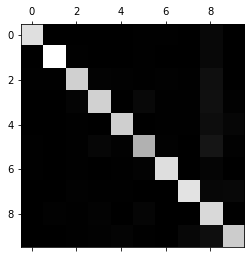

In [63]:
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show() 

You can see that most values are on the diagonal, which is a good thing, since that means those instances were classified correctly. Remember that a perfect classifier would've had only non-zero values in its diagonals. 

But let's focus on the errors the classifier made, so lets divide each value in the confusion matrix by the number of instances there are. That way we can compare error rates instead of absolute errors, which would make more abundant classes look unfairly bad. 

In [64]:
row_sums = conf_mx.sum(axis = 1, keepdims = True)#Summing rows to obtain number of (actual)instances in each class
norm_conf_mx = conf_mx/row_sums #Normalizing the values

Lets fill the diagonal with zeros, so we keep only the errors and plot the results

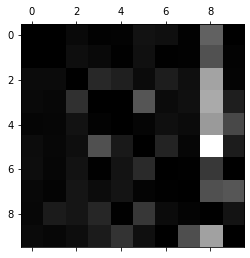

In [66]:
np.fill_diagonal(norm_conf_mx, 0 )#Using the normalized matrix and substituting the diagonals
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)#mapping it to a grayscale value
plt.show()

We can see the kinds of errors the classifier makes, for example, the 8 column is pretty lit up, which means many classes (actual classes are represented by the rows) are falsely labeled as 8's. Also, we can see that 3's and 5's are being confused.

There are several ways of fixing these kinds of problems if we understand what our classifier is messing up with, preprocessing the images or writing algorithms that can identify specific parameters such as loops in the number could be fixes that would improve the task. 

#### Multilabel Classification 

We've been working with classifiers that assign any instances only one class. In many cases we want to output multiple classes for each instance. 

This is called multilabel classification system

In [71]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)#True for big numbers
y_train_odd = (y_train % 2 == 1)#true for odd numbers (using the mod command)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()#Create a KNeighbors instance
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

This creates a y_multilabel array that contains two target labels for each instance, saying whether that instance is large (7,8,9) or odd. 

KNeighborsClassifier supports multilabel classification tasks, although there are other classifiers that don't.

In [73]:
knn_clf.predict([some_digit])#Should oputput false(not large) and true(odd)

array([[False,  True]])

The prediction of course outputs two labels.

We can evaluate multilabel classifiers in a number of ways. One is to use the F1 score for each individual label and then compute the average score.


In [74]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv = 3)
f1_score(y_multilabel, y_train_knn_pred, average = 'macro')

0.976410265560605

This assumes that all labels are equally important. If we had more a targel label that appears a lot more often that others in instances, we would perhaps want it to have a bigger score in evaluation scores. We can set this up by setting the parameter average = 'weighted'

#### Multioutput Classification

Multioutput multiclass classification is a generalization of a multiclass classifier where each label has more than two possible outputs (in the case of the other multiclass classifier, the labels were binary). 

For example, the following system cleans up a noisy image. It takes in the noisy picture as an input and outputs a clean digit image. 

Here, the each pixel is a label, because thats what you want it to predict, and each label can have multiple outputs. 

In [79]:
noise = np.random.randint(0,100,(len(X_train),784))#Creating noise for each pixel
X_train_mod = X_train + noise
noise = np.random.randint(0,100,(len(X_test), 784))#Same thing for the test set
X_test_mod = X_test + noise
y_train_mod = X_train #The new targel labels are the clean (original) MNIST images
y_test_mod = X_test

In [84]:
#From Github
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

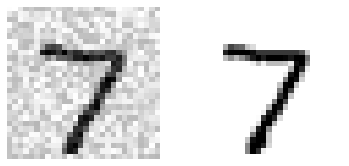

In [83]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

Now lets train a KNN classifier and see if it can clean the image on the left to look like an image to the right.

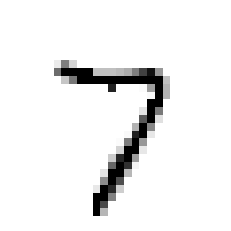

In [85]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)